In [5]:
#importing all the necessary libraries
import torch
import torch.nn as nn
import torch.functional as F
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader,TensorDataset, random_split, WeightedRandomSampler
import torch.optim as optim
from torchsummary import summary

In [ ]:
data=pd.read_excel('total_fall_2023.xlsx')
inputs=data.drop(['admitted'],axis=1).to_numpy()
labels=data['admitted'].to_numpy()
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    inputs, labels, test_size=0.2, random_state=42, stratify=labels
)
# Convert to PyTorch tensors only once
train_inputs = torch.from_numpy(train_inputs).float()
test_inputs = torch.from_numpy(test_inputs).float()
train_labels = torch.from_numpy(train_labels).int()
test_labels = torch.from_numpy(test_labels).int()
input_embedding_dimension=len(set(inputs[:,0]))
input_embedding_dimension
#The TensorDataset class in PyTorch is a utility class that is used to wrap data tensors (such as features and labels)
#This class is particularly useful when you want to work with datasets where features and labels are already stored as tensors.
train_dataset = TensorDataset(train_inputs, train_labels)
test_dataset = TensorDataset(test_inputs, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
print("Checking train_inputs for NaN:", torch.any(torch.isnan(train_inputs)))
print("Checking train_inputs for Inf:", torch.any(torch.isinf(train_inputs)))
print("Checking train_labels for NaN:", torch.any(torch.isnan(train_labels)))
print("Checking train_labels for Inf:", torch.any(torch.isinf(train_labels)))

Checking train_inputs for NaN: tensor(False)
Checking train_inputs for Inf: tensor(False)
Checking train_labels for NaN: tensor(False)
Checking train_labels for Inf: tensor(False)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

class NeuralNetwork(nn.Module):
    def __init__(self, i, h_size, h_next_size, h_next_next_size=32, n_classes=2,
                 how_many_layers=4, embedding_dim=12,hs_embedding_dim=50):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]  # Total number of input features

        self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

        #embedding layer for the high school codes
        self.hs_embedding=nn.Embedding(len(set(inputs[:,4])),hs_embedding_dim)

        # Input to fc1 will be (features - 2) continuous + embedding_dim
        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        # Ensure input is float and extract categorical/continuous features
        categorical_input = X[:, 0].long()  # First column: categorical (encoded)
        hs_input = X[:, 4].long()

        #continuous_input = X[:, 1:].float() # Rest: continuous features
        continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        # Apply embedding
        embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
        hs_embedded = self.hs_embedding(hs_input)

        # Concatenate with continuous features
        X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X


net = NeuralNetwork(inputs, h_size=16, h_next_size=22, how_many_layers=4)
print(f"Expected input features to fc1: {train_inputs.shape[1] - 1 + 8}")  # Debug print
print(f"fc1 weight shape: {net.fc1.weight.shape}")  # Debug printn_epochs = 600


n_epochs = 600
learning_rate = 0.0001
decay_rate = learning_rate / n_epochs
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=decay_rate)
lambda_reg = 0.01
lambda_entropy = 0


def loss_fn(model, outputs, targets):
    # Convert labels to numpy
    y_train = train_labels.numpy()

    # Compute class weights
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

    # Convert to PyTorch tensor
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    cross_entropy = nn.functional.cross_entropy(outputs, targets,weight=class_weights_tensor)
    l2_regularization = 0
    entropy_regularization = 0

    for param in model.parameters():
        l2_regularization += torch.norm(param, p=2) ** 2
        entropy_regularization += torch.mean(torch.sum(-outputs * torch.log(outputs), dim=1))

    loss = cross_entropy + lambda_reg * l2_regularization
    return loss

def test_instance(model):
    y_t = []
    y_s = []
    loss = 0
    acc = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss += loss_fn(model, outputs, labels.long())
            y_t.extend(labels.numpy().astype('int'))
            y_s.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())

    acc = accuracy_score(y_t, y_s)
    return loss, acc

iteration = 0
counter = 0

for epoch in range(n_epochs):
    running_loss = 0.0
    total = 0  # No. of total predictions
    correct = 0  # No. of correct predictions

    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(net, outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(train_loader.dataset)  # Loss in every epoch
    epoch_acc = correct / total  # Accuracy for every epoch

    if epoch % 10 == 0 or epoch == n_epochs - 1:
        print(f'Epoch: {epoch + 1}/{n_epochs} | pLoss: {running_loss / len(inputs)} | Accuracy: {epoch_acc} | Loss: {epoch_loss}')

    if epoch % 50 == 0:
        test_loss, test_acc = test_instance(net)
        print(f'Epoch: {epoch + 1} | The test data Accuracy = {test_acc} | Test Loss = {test_loss}')

        if counter < test_acc:
            save_net = net
            counter = test_acc

y_true = []
y_scores = []
test_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = save_net(inputs)
        test_loss += loss_fn(net, outputs, labels.long())
        y_true.extend(labels.numpy().astype('int'))
        y_scores.extend(torch.sigmoid(outputs).max(axis=1).indices.numpy())


accuracy = accuracy_score(y_true, y_scores)
precision = precision_score(y_true, y_scores)
recall = recall_score(y_true, y_scores)
f1_val = f1_score(y_true, y_scores)
auc_roc = roc_auc_score(y_true, y_scores)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))


Expected input features to fc1: 55
fc1 weight shape: torch.Size([16, 108])
Epoch: 1/600 | pLoss: 2017659.4262225812 | Accuracy: 0.4523305690591936 | Loss: 1500.1185325074953
Epoch: 1 | The test data Accuracy = 0.9153705397987191 | Test Loss = 101251.7265625
Epoch: 11/600 | pLoss: 1305273.2278442383 | Accuracy: 0.9440663425793537 | Loss: 970.4633664269429
Epoch: 21/600 | pLoss: 824569.9243868315 | Accuracy: 0.946525593365742 | Loss: 613.0631408080532
Epoch: 31/600 | pLoss: 500501.5173034668 | Accuracy: 0.9493279954246497 | Loss: 372.1200872144735
Epoch: 41/600 | pLoss: 290506.6793400691 | Accuracy: 0.9506434086359737 | Loss: 215.99009616362017
Epoch: 51/600 | pLoss: 160872.88348329984 | Accuracy: 0.9516156705747784 | Loss: 119.60809180914487
Epoch: 51 | The test data Accuracy = 0.9375571820677036 | Test Loss = 8000.3525390625
Epoch: 61/600 | pLoss: 84857.80078183688 | Accuracy: 0.9512153274235059 | Loss: 63.091301696532994
Epoch: 71/600 | pLoss: 42575.58211150536 | Accuracy: 0.951615670

In [ ]:
save_net

NeuralNetwork(
  (major_embedding): Embedding(102, 12)
  (hs_embedding): Embedding(3032, 50)
  (fc1): Linear(in_features=108, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=22, bias=True)
  (fc4): Linear(in_features=22, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=2, bias=True)
)

Confusion Matrix:
 [[3598  199]
 [  31  544]]


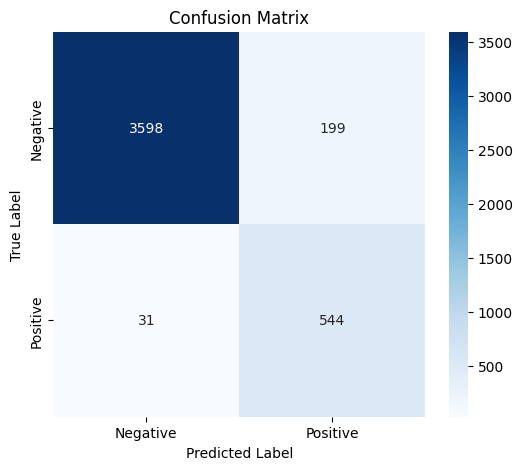

True Positives (TP): 544
False Positives (FP): 199
True Negatives (TN): 3598
False Negatives (FN): 31


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_scores)

# Print the matrix
print("Confusion Matrix:\n", cm)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_scores)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


In [ ]:
# Save the entire model (architecture + weights)
torch.save(save_net, "/content/full_model.pth")
print("Model saved successfully!")


Model saved successfully!


Index(['Application Major', 'Scholarship_Awarded', 'Application CGPA',
       'FAFSA Filed', 'High School Code', 'Financial Aid Appeal',
       'Accepted Student Day Event Attended', 'Campus Visits - Person',
       'Campus Visits - App', 'Logins Before Admit', 'Acceptance Call Success',
       'Application Consider Test Scores', 'Application ACRK',
       'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened',
       'Was Inquiry', 'Athlete', 'admitted', 'Address 1 Region_Midwest',
       'Address 1 Region_Northeast', 'Address 1 Region_South',
       'Address 1 Region_Southwest', 'Address 1 Region_Territory',
       'Address 1 Region_West', 'Application Housing_Commuter',
       'Application Housing_Residential',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Person Sex_F', 'Person Sex_M',
       'High School Region_Midwest', 'High School Region_Northeast',
       'High School Region_South', 'High School Region_Southwest',
       'High 

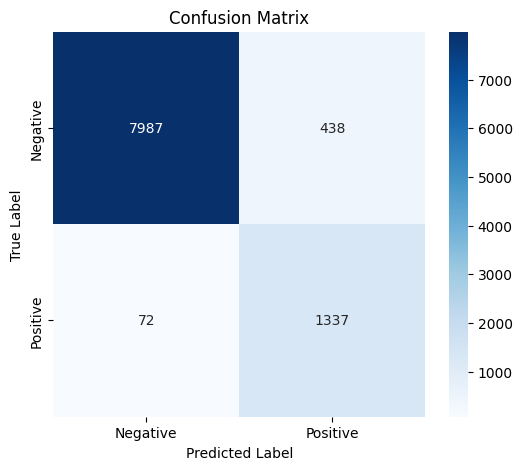

True Positives (TP): 1337
False Positives (FP): 438
True Negatives (TN): 7987
False Negatives (FN): 72


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
data_2023=pd.read_excel('/content/processed_fall_2023.xlsx')
# Ensure that new_data has the same columns as the training data except for the target column
print(data_2023.columns)
new_data = data_2023[data_2023.drop(['admitted'], axis=1).columns]
print(new_data.shape[1])
data_2023_labels=data_2023['admitted'].to_numpy()

# Load the trained model
#mymodel = torch.load("total_fall.pth")



# Make sure new_data is a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()

# Perform inference on the new data
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = save_net(new_data_tensor)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()

print("Predictions on new data:")
print(predictions)
print(len(predictions))


accuracy = accuracy_score(data_2023_labels,predictions)
precision = precision_score(data_2023_labels,predictions)
recall = recall_score(data_2023_labels, predictions)
f1_val = f1_score(data_2023_labels, predictions)
auc_roc = roc_auc_score(data_2023_labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


## fall 2025 inference

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
data_2023=pd.read_excel('/content/processed_fall_2025_031025.xlsx')
#data_2023 = data_2023_ref[data_2023_ref.drop(['Application Reference ID'], axis=1).columns]

# Ensure that new_data has the same columns as the training data except for the target column
print(data_2023.columns)
new_data = data_2023[data_2023.drop(['admitted'], axis=1).columns]
print(new_data.shape[1])
data_2023_labels=data_2023['admitted'].to_numpy()

# Load the trained model
#mymodel = torch.load("total_fall.pth")

# 1. Create a mapping for the categorical feature (first column)
# Assuming 'data' is your training DataFrame
categorical_mapping = {category: index for index, category in enumerate(data['Application Major'].unique())}

# 2. Apply mapping to new data
new_data['Application Major'] = new_data['Application Major'].map(categorical_mapping)
# Handle unseen categories (assign them to a default value, e.g., 0)
new_data['Application Major'] = new_data['Application Major'].fillna(0).astype(int)

save_net=
# Make sure new_data is a PyTorch tensor
new_data_tensor = torch.from_numpy(new_data.to_numpy()).float()

# Perform inference on the new data
with torch.no_grad():
    # Assuming your model is saved in 'save_net' after training
    outputs = save_net(new_data_tensor)

# Get predicted class labels from the outputs
predictions = torch.argmax(outputs, dim=1)

# If you want the predicted probabilities, you can use:
# probabilities = torch.softmax(outputs, dim=1)

# Convert predictions to numpy for further processing
predictions = predictions.numpy()
count_ones = (predictions == 1).sum()
print(f"Number of 1s in predictions: {count_ones}")
print("Predictions on new data:")
print(predictions)
print(len(predictions))


accuracy = accuracy_score(data_2023_labels,predictions)
precision = precision_score(data_2023_labels,predictions)
recall = recall_score(data_2023_labels, predictions)
f1_val = f1_score(data_2023_labels, predictions)
auc_roc = roc_auc_score(data_2023_labels, predictions)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1 Score: {:.4f}'.format(f1_val))
print('AUROC Score: {:.4f}'.format(auc_roc))

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Plot the Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(data_2023_labels,predictions)

# Extract TP, TN, FP, FN
TN = cm[0, 0]  # True Negative
FP = cm[0, 1]  # False Positive
FN = cm[1, 0]  # False Negative
TP = cm[1, 1]  # True Positive

print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")


Index(['Application Major', 'Scholarship_Awarded', 'Application CGPA',
       'FAFSA Filed', 'High School Code', 'Financial Aid Appeal',
       'Accepted Student Day Event Attended', 'Campus Visits - Person',
       'Campus Visits - App', 'Logins Before Admit', 'Acceptance Call Success',
       'Application Consider Test Scores', 'Application ACRK',
       'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened',
       'Was Inquiry', 'Athlete', 'admitted', 'Address 1 Region_Midwest',
       'Address 1 Region_Northeast', 'Address 1 Region_South',
       'Address 1 Region_Southwest', 'Address 1 Region_Territory',
       'Address 1 Region_West', 'Application Housing_Commuter',
       'Application Housing_Residential',
       'Application Enroll Status_Full Time',
       'Application Enroll Status_Part Time', 'Person Sex_F', 'Person Sex_M',
       'Person Sex_Unknown', 'High School Region_Midwest',
       'High School Region_Northeast', 'High School Region_South',
       'High School Reg

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self, i, h_size, h_next_size, h_next_next_size=32, n_classes=2,
                 how_many_layers=4, embedding_dim=12,hs_embedding_dim=50):
        super(NeuralNetwork, self).__init__()

        features = i.shape[1]  # Total number of input features

        self.major_embedding = nn.Embedding(input_embedding_dimension, embedding_dim)

        #embedding layer for the high school codes
        self.hs_embedding=nn.Embedding(len(set(inputs[:,4])),hs_embedding_dim)

        # Input to fc1 will be (features - 2) continuous + embedding_dim
        self.fc1 = nn.Linear(features - 2 + embedding_dim + hs_embedding_dim, h_size)
        self.layers = how_many_layers

        if self.layers == 2:
            self.fc2 = nn.Linear(h_size, n_classes)
        elif self.layers == 3:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, n_classes)
        elif self.layers == 4:
            self.fc3 = nn.Linear(h_size, h_next_size)
            self.fc4 = nn.Linear(h_next_size, h_next_next_size)
            self.fc5 = nn.Linear(h_next_next_size, n_classes)

    def forward(self, X):
        # Ensure input is float and extract categorical/continuous features
        categorical_input = X[:, 0].long()  # First column: categorical (encoded)
        hs_input = X[:, 4].long()

        #continuous_input = X[:, 1:].float() # Rest: continuous features
        continuous_indices = [i for i in range(X.shape[1]) if i not in [0, 4]]
        continuous_input = X[:, continuous_indices].float()

        # Apply embedding
        embedded = self.major_embedding(categorical_input)  # Shape: [batch_size, embedding_dim]
        hs_embedded = self.hs_embedding(hs_input)

        # Concatenate with continuous features
        X = torch.cat((embedded,hs_embedded, continuous_input), dim=1)  # Shape: [batch_size, embedding_dim + (features-1)]

        if self.layers == 2:
            X = F.relu(self.fc1(X))
            X = self.fc2(X)
        elif self.layers == 3:
            X = F.relu(self.fc1(X))
            X = F.relu(self.fc3(X))
            X = self.fc4(X)
        elif self.layers == 4:
            X = F.relu(self.fc1(X))
            X = torch.tanh(self.fc3(X))
            X = F.sigmoid(self.fc4(X))
            X = self.fc5(X)

        return X



In [ ]:
  # Ensure the predictions are a Pandas Series with the same index as new_data
import pandas as pd

predictions_series = pd.Series(predictions, index=new_data.index)

# Retrieve applications where prediction is 1
selected_applications = data_2023_ref.loc[predictions_series == 1, "Application Reference ID"]

# Display the selected Application Reference IDs
print("Application Reference IDs where prediction is 1:")
print(selected_applications)


Application Reference IDs with leading zeros (if needed) where prediction is 1:
3        845896813
8        413245739
13       953178127
19       458413143
20       232806786
           ...    
11983     27336985
11986    562261090
11994    848152522
12004    345253527
12012    442168108
Name: Application Reference ID, Length: 1751, dtype: object


In [ ]:
# Ensure 'Application Reference ID' is in string format
selected_applications = data_2023_ref.loc[predictions_series == 1, "Application Reference ID"]

# Add leading zeros to make the ID a 9-digit number
selected_applications = selected_applications.apply(lambda x: str(x).zfill(9))

# Display the selected Application Reference IDs with leading zeros
print("Application Reference IDs with 9 digits (leading zeros added where necessary) where prediction is 1:")
print(selected_applications)


Application Reference IDs with 9 digits (leading zeros added where necessary) where prediction is 1:
3        845896813
8        413245739
13       953178127
19       458413143
20       232806786
           ...    
11983    027336985
11986    562261090
11994    848152522
12004    345253527
12012    442168108
Name: Application Reference ID, Length: 1751, dtype: object


In [ ]:
selected_applications.to_csv("selected_application_idsr.csv", index=False)

print("Application IDs saved to selected_application_idsr.csv")


Application IDs saved to selected_application_idsr.csv


## lime


In [ ]:
!pip install lime
import lime
import lime.lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=ec49130959b855ec44779b1fd4cc0d4fc42b6c2240a3d882bc6f6476512b13cc
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# LIME Integration
test_inputs_np = test_inputs.numpy()

# Feature names for all 48 columns
feature_names = ['Application Major', 'Scholarship_Awarded', 'Application CGPA', 'FAFSA Filed',
                 'High School Code', 'Financial Aid Appeal', 'Accepted Student Day Event Attended',
                 'Campus Visits - Person', 'Campus Visits - App', 'Logins Before Admit',
                 'Acceptance Call Success', 'Application Consider Test Scores', 'Application ACRK',
                 'Waitlist Confirmed Date', 'Emails Sent', 'Emails Opened', 'Was Inquiry', 'Athlete',
                 'Address 1 Region_Midwest', 'Address 1 Region_Northeast', 'Address 1 Region_South',
                 'Address 1 Region_Southwest', 'Address 1 Region_Territory', 'Address 1 Region_West',
                 'Application Housing_Commuter', 'Application Housing_Residential',
                 'Application Enroll Status_Full Time', 'Application Enroll Status_Part Time',
                 'Person Sex_F', 'Person Sex_M', 'High School Region_Midwest',
                 'High School Region_Northeast', 'High School Region_South',
                 'High School Region_Southwest', 'High School Region_Territory',
                 'High School Region_West', 'Application Span', 'Admission Span',
                 'Application College_00', 'Application College_CAS', 'Application College_COB',
                 'Application College_HCLC', 'Application College_ID', 'Application College_SHS',
                 'Application College_TCOE', 'Address 1 Region_Military',
                 'High School Region_Military', 'Person Sex_Unknown']

# Debug: Verify shapes
print(f"train_inputs shape: {train_inputs.shape}")
print(f"Number of feature names: {len(feature_names)}")

# Prediction function for LIME
def predict_proba(X):
    X_tensor = torch.from_numpy(X).float()
    save_net.eval()
    with torch.no_grad():
        outputs = save_net(X_tensor)
        probs = torch.softmax(outputs, dim=1).numpy()
    return probs

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=train_inputs.numpy(),
    feature_names=feature_names,
    categorical_features=[0, 4],  # Application Major, High School Code
    class_names=['Not Admitted', 'Admitted'],
    mode='classification'
)

# Explain a test instance
instance_idx = 0
instance = test_inputs_np[instance_idx]
true_label = test_labels.numpy()[instance_idx]
print(f"\nExplaining prediction for instance {instance_idx} with true label: {true_label}")

exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=predict_proba,
    num_features=10,  # Show top 10 features (out of 48)
    num_samples=5000
)

# Show explanation
print("LIME Explanation:")
exp.save_to_file('/content/log')
exp.save_to_file('lime_explanation.html')
print("Explanation saved to 'lime_explanation.html'.")

# Print feature contributions
print("Feature Contributions:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

train_inputs shape: torch.Size([17485, 48])
Number of feature names: 48

Explaining prediction for instance 0 with true label: 0
LIME Explanation:
Explanation saved to 'lime_explanation.html'.
Feature Contributions:
Logins Before Admit <= 2.00: -0.3219
Campus Visits - App <= 0.00: 0.1387
High School Code=1810: -0.1017
Application College_00 <= 0.00: 0.0779
Address 1 Region_West <= 0.00: 0.0636
Admission Span <= 0.00: -0.0634
Waitlist Confirmed Date <= 0.00: 0.0610
Application College_COB <= 0.00: -0.0474
Application Major=32: -0.0422
Address 1 Region_Southwest <= 0.00: 0.0407
